# RuBERT news evaluator

In [1]:
# pip install transformers sentencepiece
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
# model.cuda()  # uncomment it if you have a GPU

/home/dormant/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a mode

In [2]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook
from mpl_toolkits import mplot3d

from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

plt.rcParams['figure.figsize'] = [15, 15]
plt.style.use('dark_background')

## Import news

In [3]:
news = ["lenta_news.csv", "fontanka_news.csv"]

# CHANGE 0 TO 1 TO TOGGLE NEWS SOURCE
raw_news = pd.read_csv(f"./{news[1]}", sep="\t", on_bad_lines="skip")

In [4]:
print(raw_news.shape)
raw_news.head()

(23735, 2)


,date,title
0,2020-01-01,"Четыре пешехода, МАЗ и женщина за рулём «Яндек..."
1,2020-01-01,«Мне просто не повезло». Петербургский онколог...
2,2020-01-01,Поездная романтика. Более 70 тысяч россиян вст...
3,2020-01-01,"Фотограф показал, какие пейзажи творит мороз н..."
4,2020-01-01,В новогоднюю ночь в Гатчине мужчина навеселе у...


In [5]:
def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

In [6]:
news_num = raw_news.shape[0]
length_sent = embed_bert_cls("АБОБА", model, tokenizer).shape[0]
print(f"Number of news: {news_num}")
print(f"Length of embedding: {length_sent}")

Number of news: 23735
Length of embedding: 312


In [7]:
embedder = lambda x: embed_bert_cls(x, model, tokenizer)

embed_np = np.zeros((news_num, length_sent))

for i in range(len(raw_news)):
    res = embedder(raw_news['title'][i])
    print("\r", f"i: {i}", end="")
    for j in range(len(raw_news['title'][0])): 
        embed_np[i][j] = res[j]

 i: 23734

In [8]:
embed_np = embed_np[:, np.any(embed_np, axis=0)]
cut_length = embed_np.shape[1]
print(f"Shape of stripped embedding: {embed_np.shape}")

Shape of stripped embedding: (23735, 117)


## Plot to see scatter

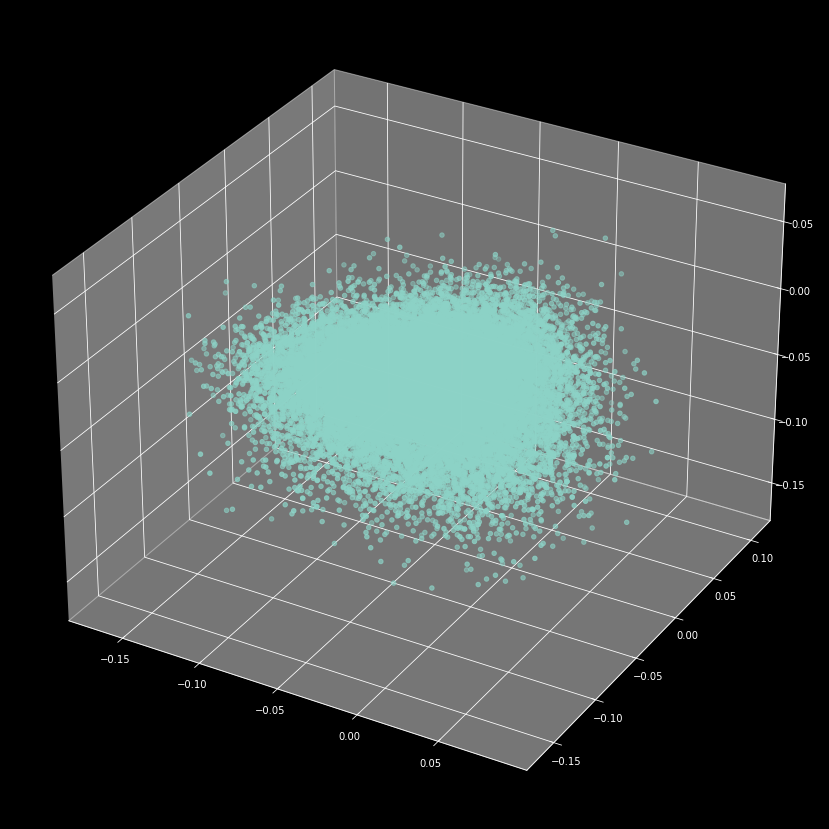

In [9]:
i = 1
j, k = i+1, i+2

x, y, z = embed_np[:, i], embed_np[:, j], embed_np[:, k]

label = raw_news['title']

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(x, y, z)
plt.show()
#for n, txt in enumerate(label):
    #print("\r", f"n: {n}    txt: {txt}", end="")
    #plt.annotate(txt, (x[n], y[n]), backgroundcolor='black')

## PCA regression to see correlations

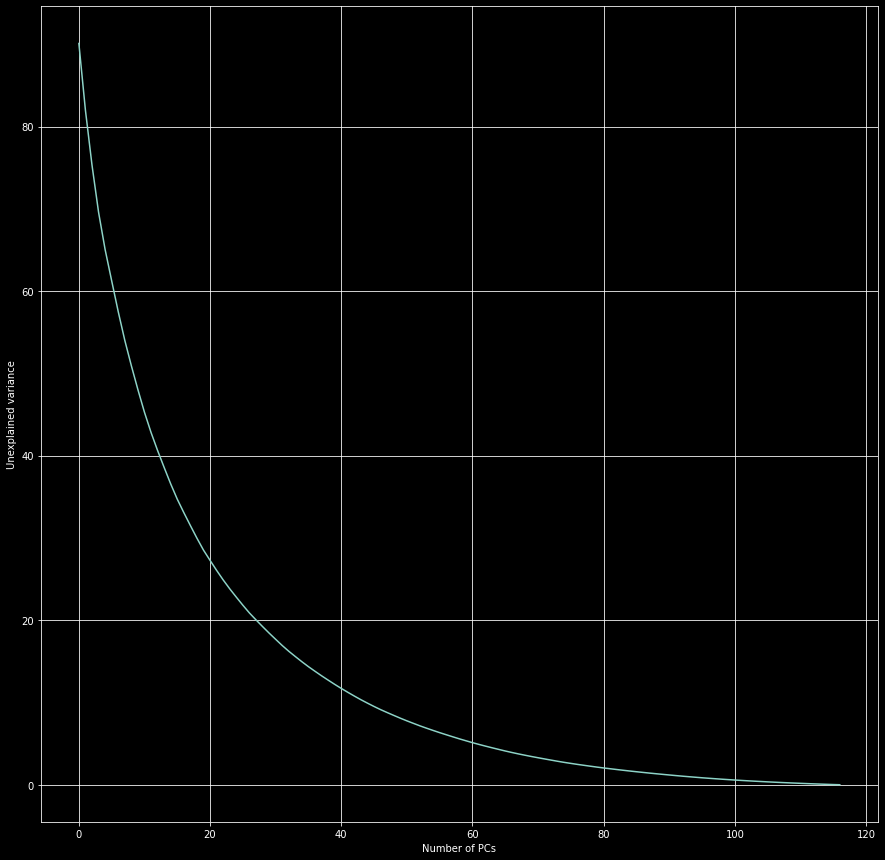

In [10]:
pca = PCA(n_components=cut_length)
pca.fit(embed_np)
exp_var = pca.explained_variance_ratio_ * 100
c_exp_var = [100 - sum(exp_var[:i+1]) for i in range(cut_length)]

plt.plot(c_exp_var)
plt.xlabel('Number of PCs')
plt.ylabel('Unexplained variance')
plt.grid()

In [11]:
n_comp = 10
pca_opt = PCA(n_components=n_comp)
pca_opt.fit(embed_np)
embed_opt = pca_opt.transform(embed_np)
print(f"Shape of transformed embedding: {embed_opt.shape}")

Shape of transformed embedding: (23735, 10)


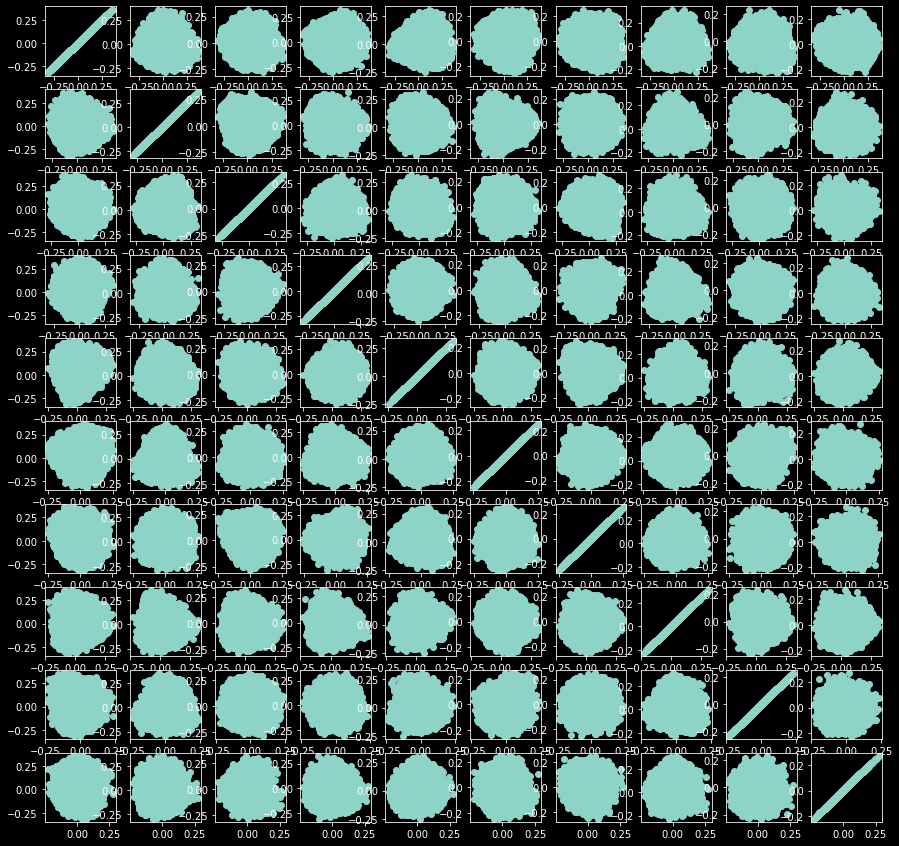

In [12]:
total_plot = 1
for i in range(n_comp):
    for j in range(n_comp):
        plt.subplot(n_comp, n_comp, total_plot)
        x, y = embed_opt[:, i], embed_opt[:, j]
        plt.scatter(x, y)
        total_plot += 1